In [61]:
import pandas as pds
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import statistics

In [66]:
#df = sns.load_dataset('iris') # load a pandas dataframe from demo file
df_i = pds.read_csv('./train.csv', sep=",") # load a pandas dataframe from csv in current directory
df_i.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Traitement du jeu de donnée
On enlève toutes les colonnes qui sont trop spécifique aux personnes et qui ne sont pas utilisable pour l'apprentissage. 
Ce traitement concerne les colonnes (PassengerId,Name,Ticket,Cabin) qui sont uniques à chaques personnes et (Embarked) qui ne peut pas avoir d'impact sur la survie ou non d'une personnes.
De plus on enlève toutes les personnes qui ont des valeurs non remplies. 

In [ ]:
m_age=df_i['Age'].median()
df_i['Age']=df_i['Age'].fillna(m_age)
df = df_i.drop(['PassengerId','Name','Ticket','Cabin'],axis=1).dropna()
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,28.0,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


On remplace les valeurs 'male' et 'female' de la colonne Sex par les valeurs 0 et 1 pour le KNN 

In [72]:
df = df.replace(['male','female'],[0,1])
df = df.replace(['S','C','Q'],[0,0.5,1])
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0.0
1,1,1,1,38.0,1,0,71.2833,0.5
2,1,3,1,26.0,0,0,7.9250,0.0
3,1,1,1,35.0,1,0,53.1000,0.0
4,0,3,0,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0.0
887,1,1,1,19.0,0,0,30.0000,0.0
888,0,3,1,28.0,1,2,23.4500,0.0
889,1,1,0,26.0,0,0,30.0000,0.5


In [73]:
df.describe()
#sorted(df['Fare'])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.350956,29.315152,0.524184,0.382452,32.096681,0.181102
std,0.486260,0.834700,0.477538,12.984932,1.103705,0.806761,49.697504,0.318079
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,0.500000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000


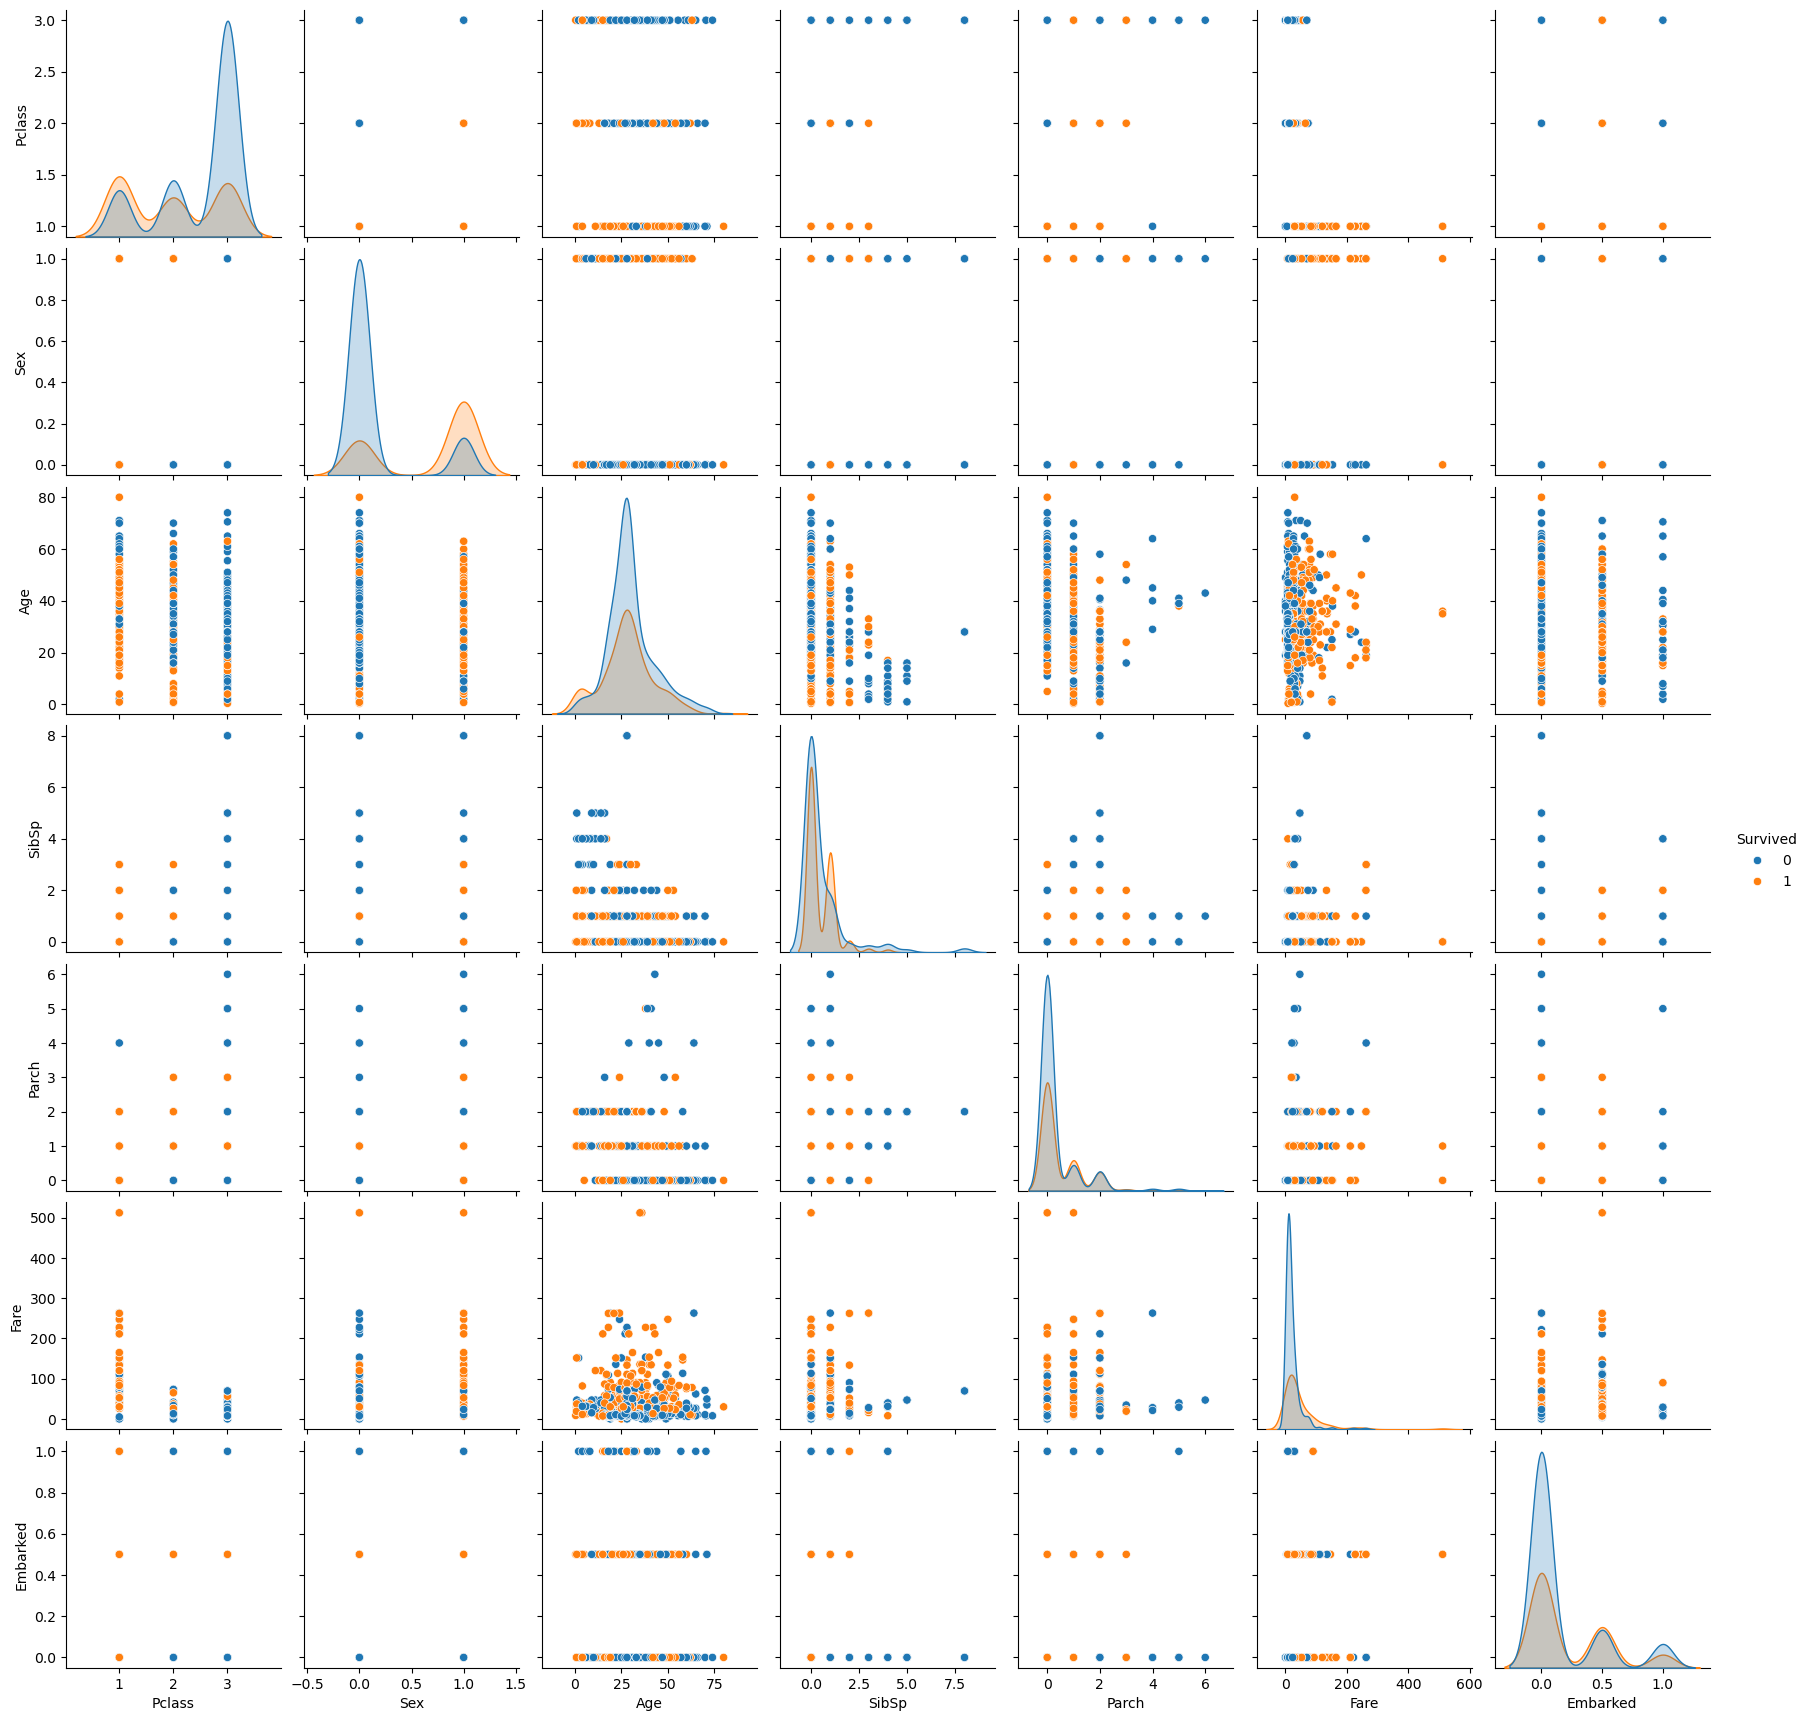

In [74]:
df2 = df.copy()
sns.pairplot(data=df2 , hue = 'Survived')

## Normalisation de nos valeurs 
Etant donnée que les colonnes ont des valeurs différentes en terme d'ordre de grandeur on normalise les valeurs sur ("Pclass","Age","SibSp","Parch","Fare") pas besoin sur Sex car déja entre 0 et 1. De plus on sépare les Colonnes explicative (X) et Expliquée (Y).


In [75]:
X = df.drop('Survived', axis=1)
Y = df['Survived']
features = ["Pclass","Age","SibSp","Parch","Fare"]
scaler = MinMaxScaler()

X_normalized = X.copy()
X_normalized[features] = scaler.fit_transform(X[features])
X_normalized

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,0,0.271174,0.125,0.000000,0.014151,0.0
1,0.0,1,0.472229,0.125,0.000000,0.139136,0.5
2,1.0,1,0.321438,0.000,0.000000,0.015469,0.0
3,0.0,1,0.434531,0.125,0.000000,0.103644,0.0
4,1.0,0,0.434531,0.000,0.000000,0.015713,0.0
...,...,...,...,...,...,...,...
886,0.5,0,0.334004,0.000,0.000000,0.025374,0.0
887,0.0,1,0.233476,0.000,0.000000,0.058556,0.0
888,1.0,1,0.346569,0.125,0.333333,0.045771,0.0
889,0.0,0,0.321438,0.000,0.000000,0.058556,0.5


On vérifie la répartition de Survivant / Mort dans notre jeu de donnée pour savoir quelle méthode de sépartion nous allons utilisée , ici environ 50 /50 don un simple split peut etre utilisé. 

In [76]:
len(df_i.loc[df_i['Survived'] == 1 ])

342

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, Y,test_size=0.3,random_state=42)

In [78]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
486,0.0,1,0.434531,0.125,0.000000,0.175668,0.0
293,1.0,1,0.296306,0.000,0.000000,0.017274,0.0
173,1.0,0,0.258608,0.000,0.000000,0.015469,0.0
450,0.5,0,0.447097,0.125,0.333333,0.054164,0.0
361,0.5,0,0.359135,0.125,0.000000,0.054107,0.5
...,...,...,...,...,...,...,...
107,1.0,0,0.346569,0.000,0.000000,0.015176,0.0
271,1.0,0,0.308872,0.000,0.000000,0.000000,0.0
862,0.0,1,0.597889,0.000,0.000000,0.050610,0.0
436,1.0,1,0.258608,0.250,0.333333,0.067096,0.0


In [79]:
y_train

486    1
293    0
173    0
450    0
361    0
      ..
107    1
271    1
862    1
436    0
103    0
Name: Survived, Length: 622, dtype: int64

In [80]:
clf=tree.DecisionTreeClassifier()
clf=clf.fit(X_train,y_train)

In [43]:
# Limiter la profondeur à 3, 4 ou 5 est idéal pour la visualisation.
modele_dt_simple = DecisionTreeClassifier(max_depth=4, random_state=42)

modele_dt_simple.fit(X_train, y_train)

# Ensuite, vous visualisez ce modèle simple
plt.figure(figsize=(15, 10))
plot_tree(
    modele_dt_simple, # <--- Utilisez le modèle simplifié
    filled=True, 
    rounded=True, 
    feature_names=X.columns.tolist(),
    class_names=modele_dt_simple.classes_.astype(str).tolist()
)
plt.show()


NameError: name 'DecisionTreeClassifier' is not defined

In [81]:
predictions_y=clf.predict(X_test)

In [82]:
from sklearn.metrics import accuracy_score

# Étape 2A : Calculer le score d'accuracy
accuracy = accuracy_score(y_test, predictions_y)

print(f"L'Accuracy de l'arbre sur le jeu de test est : {accuracy:.4f}")

L'Accuracy de l'arbre sur le jeu de test est : 0.7790


In [83]:
from sklearn.metrics import confusion_matrix, classification_report

# Étape 2B : Matrice de Confusion
matrice_conf = confusion_matrix(y_test, predictions_y)
print("\nMatrice de Confusion :")
print(matrice_conf)

# Étape 2C : Rapport de Classification (Précision, Rappel, F1-Score)
rapport_classif = classification_report(y_test, predictions_y)
print("\nRapport de Classification :")
print(rapport_classif)


Matrice de Confusion :
[[137  30]
 [ 29  71]]

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       167
           1       0.70      0.71      0.71       100

    accuracy                           0.78       267
   macro avg       0.76      0.77      0.76       267
weighted avg       0.78      0.78      0.78       267



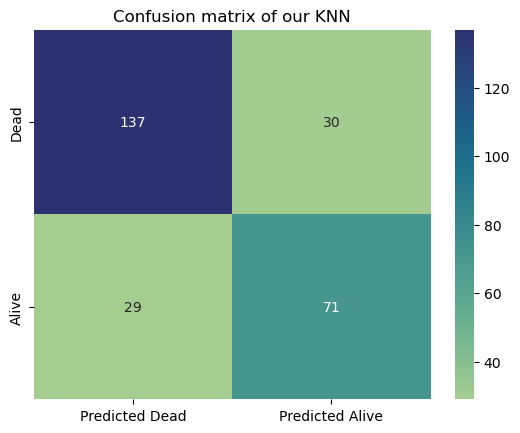

In [84]:
sns.heatmap(matrice_conf, annot=True, fmt="d", cmap="crest", xticklabels=['Predicted Dead','Predicted Alive'], yticklabels=[
    'Dead','Alive'])
plt.title("Confusion matrix of our KNN")
plt.show()